## Genre Recognition with Audio Files
This notebook GTZAN dataset with help from two Kaggle notebooks

- https://www.kaggle.com/dikshabhati2002/let-s-classify-audio-ml-dl

- https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend

## Load Pandas Packages

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Importing Librosa 
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

#Import ML and DL packages
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import cosine_similarity
import catboost as cb

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
import tensorflow as tf
import tensorflow.python.keras as k
from keras.wrappers.scikit_learn import KerasClassifier

In [6]:
import os

file_path = '/Users/kathymeyer/Desktop/Music Machine Learning Project/Data'
print(list(os.listdir(f'{file_path}/genres_original')))

['.DS_Store', 'blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Understanding audio with Librosa

Reteive and play audio features from jazz, hip hop, and rock

In [7]:
#import audio

jazz_song = '/Users/kathymeyer/Desktop/Music Machine Learning Project/Data/genres_original/jazz/jazz.00001.wav'
hip_hop_song = '/Users/kathymeyer/Desktop/Music Machine Learning Project/Data/genres_original/hiphop/hiphop.00001.wav'
rock_song = '/Users/kathymeyer/Desktop/Music Machine Learning Project/Data/genres_original/rock/rock.00001.wav'


x_jazz, sr_jazz = librosa.load(jazz_song)
x_hip_hop, sr_hip_hop = librosa.load(hip_hop_song)
x_rock, sr_rock = librosa.load(rock_song)

Play audio files and plot waves using IPython, Matplot and Librosa. The wave charts show the amplitude by time. 

In [8]:
#Jazz audio and waveplot
ipd.Audio(x_jazz, rate = sr_jazz)

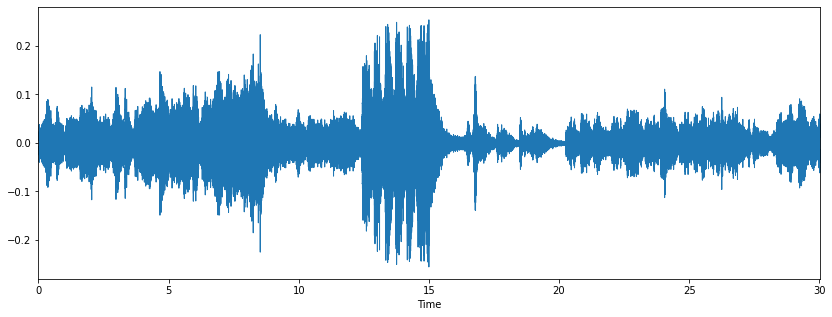

In [9]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x_jazz, sr_jazz)

In [51]:
#Hip Hop audio and waveplot #Wu Tang
ipd.Audio(x_hip_hop, rate = sr_hip_hop)

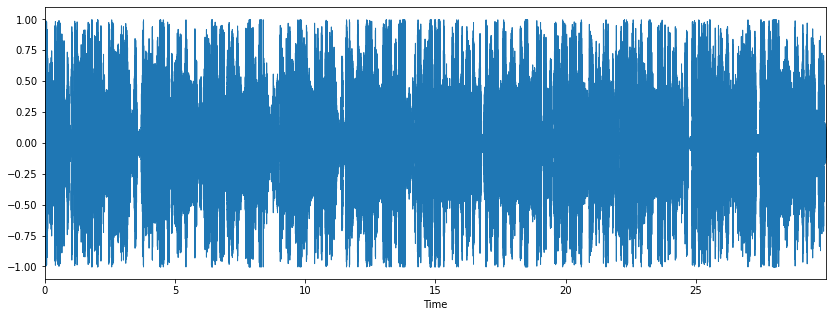

In [52]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x_hip_hop, sr_hip_hop)

In [53]:
#Rock audio and waveplot #Morpine
ipd.Audio(x_rock, rate = sr_rock)

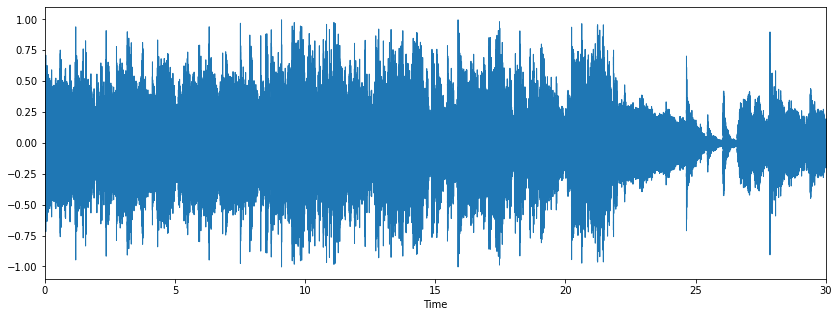

In [13]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x_rock, sr_rock)

## Look at the Audio Clips Sonic Features

#### Convert Audio Files to Numpy Arrays
Here we use Librosa Trim to easily convert our audio files to arrays for visualization

In [14]:
#Jazz
jazz_song, _=librosa.effects.trim(x_jazz)
jazz_song


array([0.00241089, 0.00549316, 0.00866699, ..., 0.00201416, 0.00250244,
       0.00119019], dtype=float32)

In [57]:
jazz_df = pd.DataFrame(jazz_song)

jazz_df.info

<bound method DataFrame.info of                0
0       0.002411
1       0.005493
2       0.008667
3       0.011719
4       0.014069
...          ...
661789 -0.004120
661790 -0.001862
661791  0.002014
661792  0.002502
661793  0.001190

[661794 rows x 1 columns]>

In [15]:
#Hip Hop
hip_hop_song, _=librosa.effects.trim(x_hip_hop)
hip_hop_song


array([ 0.0480957 , -0.20150757, -0.25741577, ..., -0.01766968,
       -0.0352478 , -0.00881958], dtype=float32)

In [16]:
#Rock
rock_song, _=librosa.effects.trim(x_rock)
rock_song


array([0.36239624, 0.6494751 , 0.6317444 , ..., 0.04336548, 0.0557251 ,
       0.05700684], dtype=float32)

#### Harmonics and Perceptual

 - Harmonics are characteristics such as pitch and melody. Think of a violin. 
 
 - Perceptual understanding shock wave represents the sound rythm and emotion. 
 
 - Can you see the variations between each genre? 

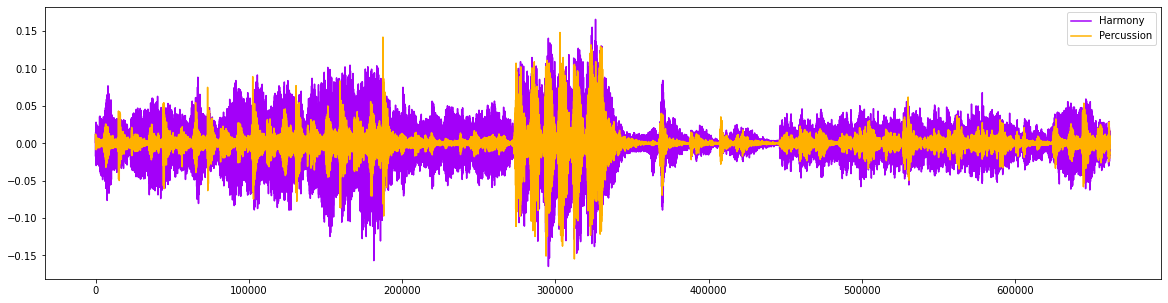

In [69]:
#Jazz harmonics and perceptual

y_jazz_harm, y_jazz_perc = librosa.effects.hpss(jazz_song)
plt.rcParams["figure.figsize"] = (20,5)
jazz_harm = plt.plot(y_jazz_harm, color = '#A300F9', label='Harmony')
jazz_perc = plt.plot(y_jazz_perc, color = '#FFB100', label='Percussion')
plt.legend(['Harmony', 'Percussion'])

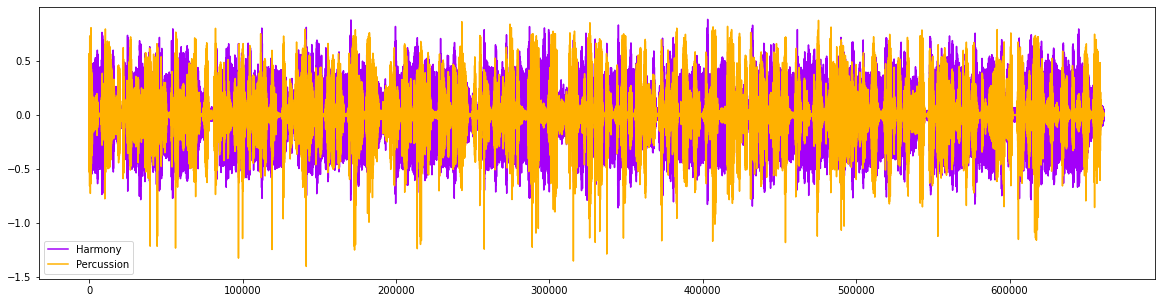

In [85]:
#Hip Hop harmonics and perceptual

y_hip_hop_harm, y_hip_hop_perc = librosa.effects.hpss(hip_hop_song)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(y_hip_hop_harm, color = '#A300F9')
plt.plot(y_hip_hop_perc, color = '#FFB100')
plt.legend(['Harmony', 'Percussion'])

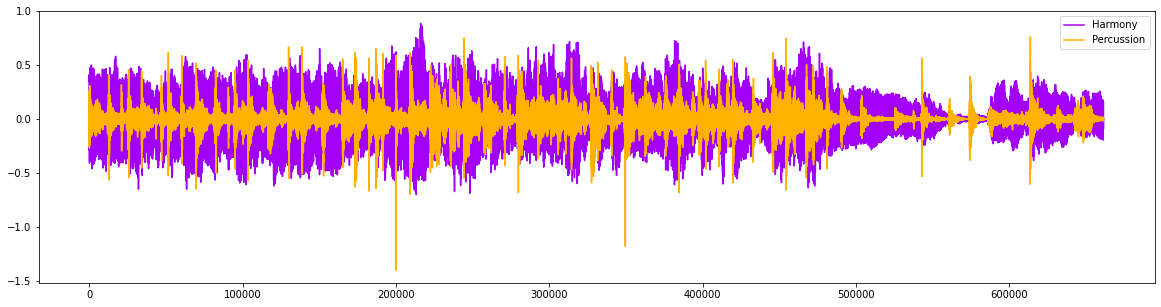

In [86]:
#Rock harmonics and perceptual

y_rock_harm, y_rock_perc = librosa.effects.hpss(rock_song)
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(y_rock_harm, color = '#A300F9')
plt.plot(y_rock_perc, color = '#FFB100')
plt.legend(['Harmony', 'Percussion'])

### Now we are going to look at the Mel-Spectograms (Mel Frequency Cepstral Co-efficients) of each audio file

 - The Fourier transform is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a spectrum.
 
 - short-time Fourier transform allows us to measure the transform over time (also called an FFT) and the output is a spectogram. 
 
 - Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same.
 
 
 - In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called   the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.
 
 
Source: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53




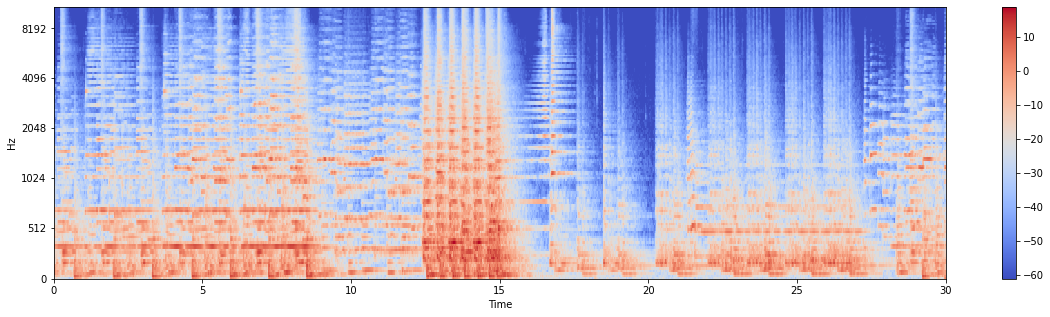

In [78]:
#Jazz Spectogram
s_jazz = librosa.feature.melspectrogram(x_jazz, sr=sr_jazz, power=2.0)
sdb_jazz = librosa.power_to_db(s_jazz)

plt.rcParams["figure.figsize"] = (20,5)
librosa.display.specshow(sdb_jazz, sr=sr_jazz, x_axis='time', y_axis='mel')
plt.colorbar()

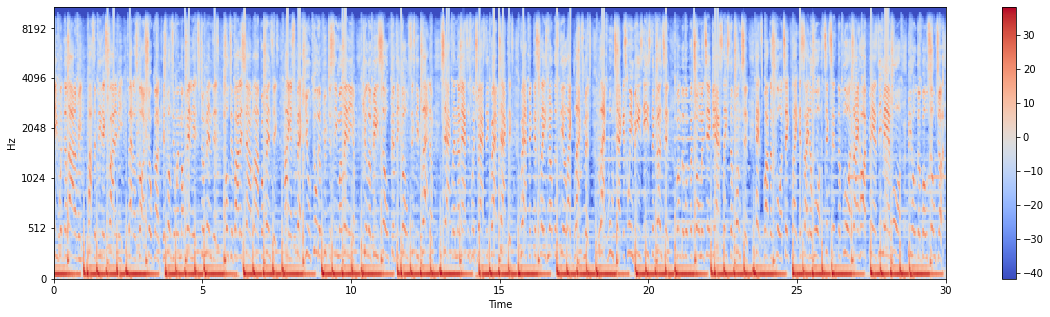

In [21]:
# Hip Hop Spectogram
s_hip_hop = librosa.feature.melspectrogram(x_hip_hop, sr=sr_hip_hop, power=2.0)
sdb_hip_hop = librosa.power_to_db(s_hip_hop)

plt.rcParams["figure.figsize"] = (20,5)
librosa.display.specshow(sdb_hip_hop, sr=sr_hip_hop, x_axis='time', y_axis='mel')
plt.colorbar()


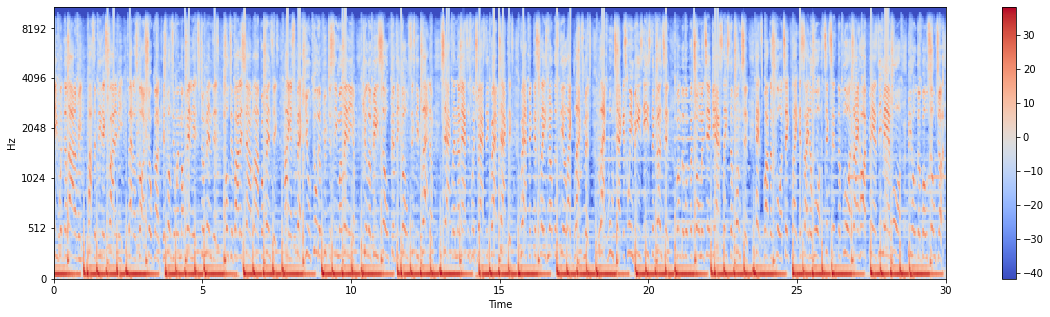

In [22]:
# Rock Spectogram
s_rock = librosa.feature.melspectrogram(x_rock, sr=sr_rock, power=2.0)
sdb_rock = librosa.power_to_db(s_hip_hop)

plt.rcParams["figure.figsize"] = (20,5)
librosa.display.specshow(sdb_rock, sr=sr_rock, x_axis='time', y_axis='mel')
plt.colorbar()

#### Mel -Frequency Cepstral Coefficients

 - The Mel frequency cepstral coefficients (MFCCs) of a signal are the small set of "features" (usually 10-20) which concisely describe the overall    shape of a spectral envelope. It models the characteristics of the human voice. 

In [80]:
#MFFCs

jazz_mfcc = librosa.feature.mfcc(jazz_song, sr = sr_jazz)
hip_hop_mfcc = librosa.feature.mfcc(hip_hop_song, sr = sr_hip_hop)
rock_mfcc = librosa.feature.mfcc(rock_song, sr = sr_rock)
jazz_mfcc_df = pd.DataFrame(jazz_mfcc)
jazz_mfcc_df.head(30)

0           1           2           3           4           5     \
0  -421.225464 -433.731140 -446.985809 -452.072998 -444.219727 -405.501221   
1   205.380310  203.940277  198.269257  198.722046  195.513596  187.605591   
2     8.275852   14.478586   21.756313   27.205017   17.209002   -3.789458   
3    10.232468   10.809992   12.763008   15.467442   17.546179   23.548286   
4    10.293510   12.924225   10.289561   13.997962   20.944355   10.345264   
5    -0.800359   -1.840438   -0.260502    0.207944    5.676028   13.655918   
6     5.926394    5.140420    7.000704    4.284086   -0.882799   -4.994486   
7    -3.083993   -6.627339  -11.271278   -9.364587  -16.610445  -24.874863   
8    -0.385048   -7.361441  -12.433941   -8.114016   -3.871951    2.634001   
9    11.971700   10.307219    6.466215    6.024918    8.467049    1.703286   
10   10.868852   11.728094    8.130123    2.693354    1.209330    0.253224   
11    1.704144    2.430799    2.848085    0.180762    1.747340   11.384638   
12   -3.649063   -4.638251   -3.143899   -0.517424   -3.786205    1.107302   
13    0.744285   -2.335727   -0.802509    0.024814   -4.481871    0.991101   
14    4.617991    4.851664    6.787800    5.480666    9.558624    4.297637   
15    0.573787    2.067204    2.355040    1.955996    5.000808   -3.634158   
16    1.282259   -2.110889   -2.446510   -4.182707   -7.866601   -7.024275   
17    3.982368   -0.992285   -1.733965   -3.006742   -5.618647   -6.714098   
18    6.282035    2.812403    0.331609    0.713074   -2.397585    4.337282   
19   11.195224   10.381108    7.317399    7.432919    4.456774    3.586562   

          6           7           8           9     ...        1283  \
0  -393.008606 -398.219879 -403.625305 -377.294403  ... -390.064148   
1   179.972656  176.661072  174.204712  143.743256  ...  212.413269   
2   -11.595343   -9.036511   -4.544716    1.490014  ...   -8.709934   
3    25.461220   25.108913   23.377571   17.575384  ...   10.547956   
4     3.868157    2.811050   -0.466408    5.748008  ...   18.862415   
5    13.235790   12.016316   11.179523    5.833616  ...    8.175312   
6    -9.129881   -8.776340   -8.003757   -8.994843  ...   -1.401491   
7   -29.101864  -29.032377  -28.226973  -24.731895  ...   -9.740467   
8     1.644696   -1.828164   -7.212649  -10.610227  ...   -1.913200   
9    -0.406491    0.982583    0.229076   -2.768687  ...   -0.086907   
10   -0.145264    1.712126    1.358061   -0.355262  ...    6.677865   
11   11.622890   10.014731    9.440475    8.144989  ...    5.599987   
12    3.297844    4.687902    5.771974   12.156256  ...    1.507255   
13    1.413331    5.325826    7.290046    3.275479  ...   -3.321203   
14    3.377253    8.787157   10.236860    4.759482  ...   -6.656675   
15   -6.141347   -3.850671   -5.493761   -1.005829  ...    6.465830   
16  -11.312754  -15.193533  -17.074411  -14.142754  ...    5.463435   
17  -10.578548  -13.808683  -13.530948  -15.715340  ...   -6.188571   
18    7.756365    7.475208    7.906035    2.407281  ...   -7.274044   
19    8.443584   16.887177   17.057081   15.074202  ...   -0.410098   

          1284        1285        1286        1287        1288        1289  \
0  -400.345001 -407.428497 -408.872406 -419.168274 -403.575195 -366.409393   
1   209.718719  211.277222  209.018494  203.575516  192.774811  173.270920   
2    -5.548037    3.084436    1.955826    4.266571  -14.244795  -27.293793   
3     7.514454   11.748041   10.543777   14.029037   23.243546   27.529305   
4    18.641960   18.816772   15.880074   21.987152   22.297333    8.951916   
5    10.421200    5.882331    6.078629   12.240676   11.538687   19.146042   
6     0.278349   -0.871812    4.235638   10.485195   12.761369    6.388298   
7   -10.220896  -10.343265   -6.407807   -5.972770  -11.519506   -9.475398   
8    -1.713482   -1.699111   -2.521279   -6.323252   -8.260322   -3.792683   
9     1.553009    4.828862    2.367469   -0.177331   -0.610510   -5.219510   
10    2.795441    4.4

In [24]:
print(jazz_mfcc.shape)
print(hip_hop_mfcc.shape)
print(rock_mfcc.shape)



(20, 1293)
(20, 1293)
(20, 1293)


We'll need to scale our MFCC's

In [25]:
#Perform our feature scaling

jazz_mfcc_scale = sklearn.preprocessing.scale(jazz_mfcc, axis = 1)
hip_hop_mfcc_scale = sklearn.preprocessing.scale(hip_hop_mfcc, axis = 1)
rock_mfcc_scale = sklearn.preprocessing.scale(rock_mfcc, axis = 1)

#### Let's viz our work

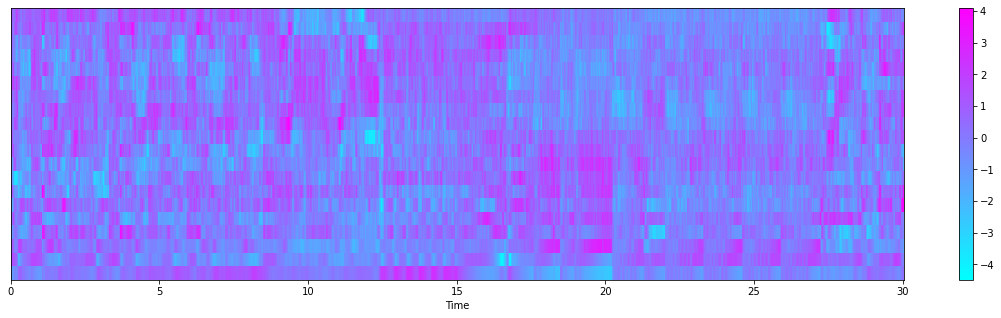

In [26]:
#Jazz Spec MFCCs

plt.rcParams["figure.figsize"] = (20,5)
librosa.display.specshow(jazz_mfcc_scale, sr=sr_jazz, x_axis='time', cmap = 'cool')
plt.colorbar()



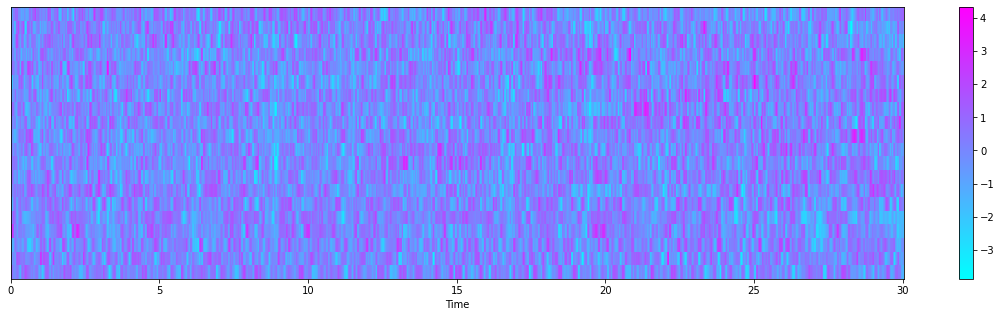

In [27]:
#Hip Hop Spec MFCCs

plt.rcParams["figure.figsize"] = (20,5)
librosa.display.specshow(hip_hop_mfcc_scale, sr=sr_hip_hop, x_axis='time', cmap = 'cool')
plt.colorbar()

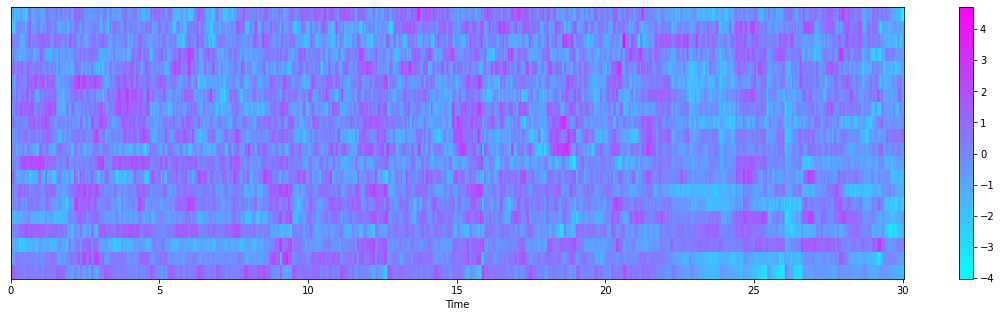

In [28]:
#Rock Spec MFCCs

plt.rcParams["figure.figsize"] = (20,5)
librosa.display.specshow(rock_mfcc_scale, sr=sr_rock, x_axis='time', cmap = 'cool')
plt.colorbar()

## Exploratory Data Analysis (EDA)
For this section we will use the 30 second audio data set to explore across genres. This section was developed from Andrada Olteanu's Kaggle notebook (see references at the top of this notebook). 


In [84]:
thirty_data = pd.read_csv(f'{file_path}/features_30_sec.csv')
thirty_data.columns



Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

#### Correlation Heatmap for feature means

 - A correlation matrix is simply a table which displays the correlation coefficients for different variables. The matrix depicts the correlation between all the possible pairs of values in a table. It is a powerful tool to summarize a large dataset and to identify and visualize patterns in the given data.
 
 
Source: https://corporatefinanceinstitute.com/resources/excel/study/correlation-matrix/

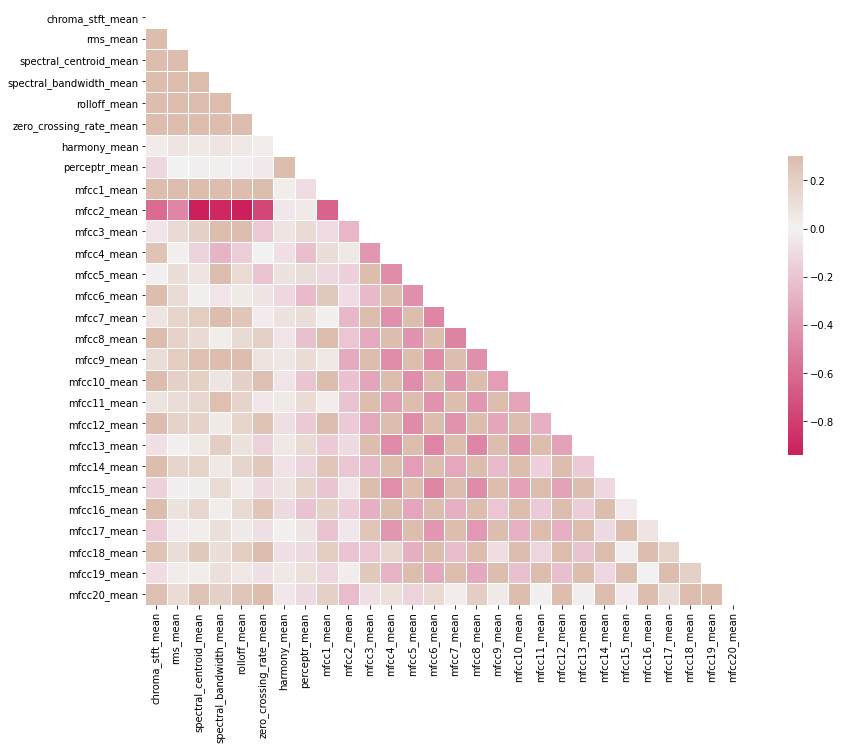

In [30]:
#Compute the Correlation Matrix
spike_cols = [col for col in thirty_data.columns if 'mean' in col]
corr = thirty_data[spike_cols].corr()

#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplot figure
f, ax = plt.subplots(figsize=(16, 11));

#Generate a custom diverging colormap

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax = .3, center = 0, 
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

params = {'xtick.labelsize': 10, 'ytick.labelsize': 10}
plt.rcParams.update(params)

plt.savefig("Corr Heatmap Music.jpg")

#### Boxplot for genre distribution by Tempo

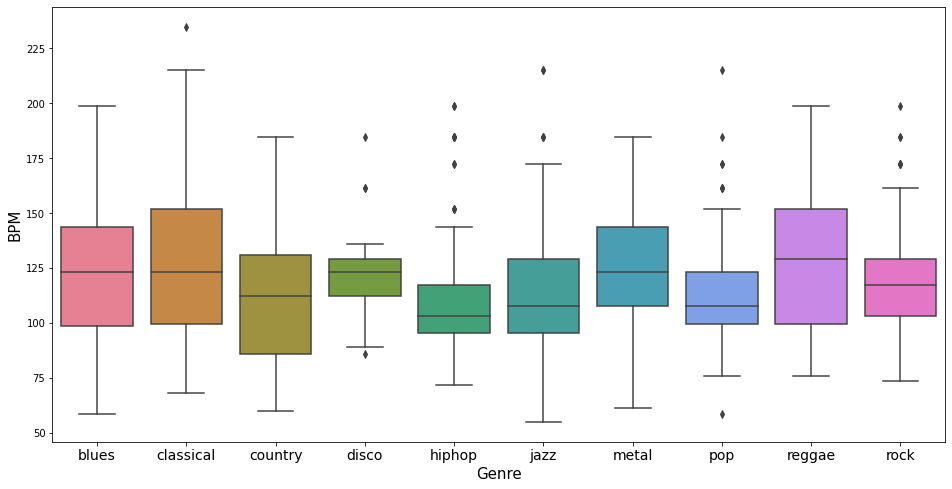

In [27]:
x = thirty_data[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

## Machine Learning Classification
For this section, we will be using the 3 second data file which breaks up each 30 second audiofile into 10 3 second rows. More data means better ML. 

In [28]:
three_data = pd.read_csv(f'{file_path}/features_3_sec.csv')
three_data = three_data.iloc[0:,1:]
three_data.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

#### Features and Target

 - creates the target and feature variables
 
 - normalize the data

In [29]:
#Genre variable
genre = three_data['label']

#Select all columns but not the label
ml_x = three_data.loc[:, three_data.columns !='label']

#Normalize so eeverything is on the same scale
cols = ml_x.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(ml_x)

#Create a new data frame for ML
ml_data = pd.DataFrame(np_scaled, columns=cols)
ml_data.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0     0.0          0.355399         0.716757  0.293133  0.107955   
1     0.0          0.367322         0.670347  0.253040  0.044447   
2     0.0          0.373159         0.728067  0.296753  0.141663   
3     0.0          0.399349         0.677066  0.298024  0.075042   
4     0.0          0.355668         0.689113  0.322308  0.052149   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                0.262173               0.034784                 0.459205   
1                0.270969               0.018716                 0.470831   
2                0.265293               0.023073                 0.494051   
3                0.238427               0.023187                 0.455246   
4                0.233460               0.016451                 0.451651   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0                0.094130      0.346153  ...     0.363613    0.056198   
1                0.052261      0.363722  ...     0.468596    0.092912   
2                0.059922      0.378215  ...     0.479681    0.096704   
3                0.066234      0.329587  ...     0.386258    0.067995   
4                0.047830      0.318453  ...     0.438567    0.042500   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     0.397172    0.066062     0.371828    0.055344     0.380831    0.026797   
1     0.351681    0.074001     0.362068    0.076365     0.418452    0.082414   
2     0.420979    0.050639     0.400536    0.067509     0.433742    0.043841   
3     0.387474    0.050617     0.380430    0.050030     0.405824    0.041898   
4     0.460314    0.083860     0.388590    0.076524     0.409019    0.020763   

   mfcc20_mean  mfcc20_var  
0     0.506746    0.047781  
1     0.593029    0.065548  
2     0.546264    0.036062  
3     0.562204    0.034873  
4     0.517913    0.031713  

[5 rows x 58 columns]

Now we will split the data into a training and testing. Here we will use a 70-30% split

In [30]:
ml_data_train, ml_data_test, genre_train, genre_test = train_test_split(ml_data, genre, test_size=0.3, random_state=42)

#### Create a predifined function to assess the accuracy of a model
 - input is the model
 - fits the model on the training dataset
 - predicts on the testing features
 - compares the predictions with the actuals

In [31]:
def model_assess(model, title = 'Default'):
    model.fit(ml_data_train, genre_train)
    preds = model.predict(ml_data_test)
    
    print('Accuracy', title, ':', round(accuracy_score(genre_test, preds), 5), '\n')

#### Trying 13 different models to assess their performance. The Kernel below includes information on each classifier.

 - [Naive Bays Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
 
 - [Stochastic Gradient Descent](https://scikit-learn.org/stable/modules/sgd.html)
 
 - [K Nearest Neighbor](https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55)

 - [Decision Tree](https://www.kdnuggets.com/2020/01/decision-tree-algorithm-explained.html)
 
 - [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 
 - [Support Vector Machine](https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/)
 
 - [Multi-layer Perceptron classifier](https://analyticsindiamag.com/a-beginners-guide-to-scikit-learns-mlpclassifier/)
 
 - [catboost](https://towardsdatascience.com/why-you-should-learn-catboost-now-390fb3895f76)
 
 - [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 
 - [Cross Gradient Booster](https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/)
 
 - [Cross Gradient Booster (Random Forest)](https://www.kdnuggets.com/2019/07/xgboost-random-forest-bayesian-optimisation.html)
 
 - [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [33]:
#Naive Bayes
nb = GaussianNB()
model_assess(nb, 'Naive Bayes')

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(nb, 'Stochastic Gradient Descent')

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, 'KNN')

#Decision Tree
tree = DecisionTreeClassifier()
model_assess(tree, 'Decision Trees')

#Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape='ovo')
model_assess(svm, 'Support Vector Machine')

#Multi-layer Perceptron classifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, 'Neural Networks')

#catboost
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
model_assess(cbc, 'Cat Boost Classifier')

#Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, 'Log Regression')

#Cross Gradient Booster
xgb = XGBClassifier(objective= 'multi:softmax')
model_assess(xgb, 'Cross Gradient Booster')

#Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

#AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
model_assess(clf, "AdaBoostClassifier")


Accuracy Naive Bayes : 0.51952 

Accuracy Stochastic Gradient Descent : 0.51952 

Accuracy KNN : 0.80581 

Accuracy Decision Trees : 0.64097 

Accuracy Random Forest : 0.81415 

Accuracy Support Vector Machine : 0.75409 

Accuracy Neural Networks : 0.67601 

Accuracy Cat Boost Classifier : 0.91124 

Accuracy Log Regression : 0.6977 

[16:57:17] WARNING: /private/var/folders/wp/b144_9d17kgdql63wpgwpvsm0000gn/T/pip-install-ts2beo8e/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster : 0.89723 

[16:58:10] WARNING: /private/var/folders/wp/b144_9d17kgdql63wpgwpvsm0000gn/T/pip-install-ts2beo8e/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the ob

## The winner is Cat Boost Classifier at 91% !!!

Accuracy : 0.91124 



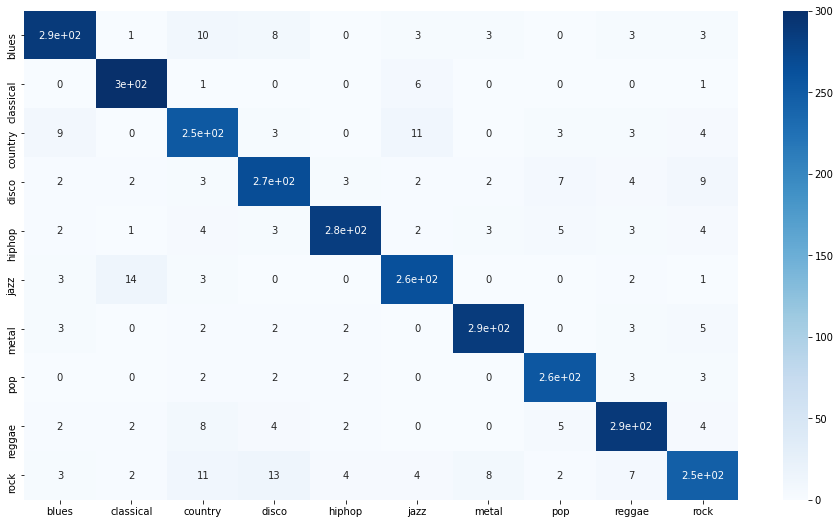

In [39]:
#Final Model
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(ml_data_train, genre_train,)

preds = cbc.predict(ml_data_test)

print('Accuracy', ':', round(accuracy_score(genre_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(genre_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

#### Feature Importance


In [37]:
#used to inspect ML classifiers and explain their predictions

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=cbc, random_state=1)
perm.fit(ml_data_test, genre_test )

eli5.show_weights(estimator=perm, feature_names = ml_data_test.columns.tolist())